# Softmax

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os


## Softmax-Funktion

Die Softmax-Funktion ist eine mathematische Funktion, die in der Regel in der letzten Schicht eines neuronalen Netzwerks verwendet wird, insbesondere bei Klassifikationsproblemen. Sie nimmt einen Vektor von Rohwerten (Logits) und transformiert ihn in einen Vektor von Wahrscheinlichkeiten, wobei die Summe aller Wahrscheinlichkeiten gleich 1 ist.

Gegeben sei ein Vektor von Ausgaben des neuronalen Netzwerkes $ z = (z_1, z_2, \ldots, z_n) $,
Die Funktion wird wie folgt definiert:
$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}
$$

In Worten ausgedrückt: Für jedes Element $ z_i $ im Vektor $ z $ berechnet die Softmax-Funktion den Exponentialwert von $ z_i $ und teilt diesen durch die Summe der Exponentialwerte aller Elemente im Vektor.

### Torch vorbereiten

In [2]:
# Wir prüfen ob eine Hardwarebeschleunigung möglich ist und verwenden diese, wenn sie verfügbar ist
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
torch.manual_seed(42) # Setze den Zufallsseed für Reproduzierbarkeit
print(f"Using {device} device")

Using cpu device


## MNIST Dataset vorbereiten, laden und visualisieren

Wir nutzen für dieses Notebook den MNIST-Datensatz, der handgeschriebene Ziffern enthält. Die Ziffern sind in 10 Klassen (0-9) unterteilt, und jede Klasse enthält Tausende von Bildern. 
Die Bilder sind in Graustufen und haben eine Auflösung von 28x28 Pixeln.
Das Modell muss lernen, diese Ziffern korrekt zu klassifizieren.

Wir werden diesen Datensatz laden, vorbereiten und einige Beispiele visualisieren. Der Datensatz kann direkt von PyTorch heruntergeladen werden, was den Prozess vereinfacht.

Quelle Dataset: [MNIST Dataset](https://pytorch.org/vision/stable/datasets.html#mnist)

Originale nicht mehr existierende Webseite: [MNIST Dataset](http://yann.lecun.com/exdb/mnist/)

In [3]:
# Mnist Dataset laden
mnist_train = torchvision.datasets.MNIST(root='datasets', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='datasets', train=False, download=True)

# Damit wir die Bilder in einem CNN verwenden können, müssen wir die Bilder in Tensoren umwandeln.

transform = torchvision.transforms.ToTensor()

# Mit der Bibliothek Torchvision können wird das MNIST Dataset direkt herunterladen und in einem Schritt in Tensoren umwandeln. 
# Train=True lädt den Trainingsdatensatz, Train=False lädt den Testdatensatz.
mnist_transformed_train = torchvision.datasets.MNIST(root='datasets', train=True, download=True, transform=transform)
mnist_transformed_test = torchvision.datasets.MNIST(root='datasets', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_transformed_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_transformed_test, batch_size=64, shuffle=True)

### Modell erstellen

In [4]:
# TODO erstellen Sie mit torch.nn.sequential ein Convolutional Neural Network mit folgenden Schichten. Die Schichten werden als einzelne Parameter an torch.nn.Sequential übergeben.
# - Convolutional Layer mit einem Eingabe-Kanal, 12 Ausgabekanälen, einem Kernel von 7x7, einem Stride von 1 und einem Padding von 0
# - Max Pooling Layer mit einem Kernel von 2x2 und einem Stride von 2
# - RELU Aktivierungsfunktion
# - Convolutional Layer mit 12 Eingabekanälen, 16 Ausgabekanälen, einem Kernel von 5x5, einem Stride von 1 und einem Padding von 2
# - Max Pooling Layer mit einem Kernel von 2x2 und einem Stride von 2
# - RELU Aktivierungsfunktion
# - Flatten Layer, um die Daten für die Fully Connected Layer vorzubereiten
# - Fully Connected Layer mit der Anzahl Eingabeneuronen die Sie oben berechnet haben und 10 Ausgabeneuronen.

model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=12, kernel_size=7, stride=1, padding=0),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5, stride=1, padding=2),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=16*5*5, out_features=10),
)

### Netzwerk trainieren

In [5]:
# Testen ob das File für das Modell existiert und das Modell geladen werden kann, ansonsten wird das Modell trainiert und gespeichert.
if os.path.exists("mnist_cnn.pth"):
    model.load_state_dict(torch.load("mnist_cnn.pth"))
    print("Modell erfolgreich geladen!")
else:
    # Hyperparameter definieren
    max_num_epochs = 10
    learning_rate = 0.001
    momentum = 0.9

    # Optimizer und die Loss-Funktion definieren
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    loss = torch.nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []

    # Das Modell muss noch auf die Hardware verschoben werden.
    model.to(device)

    for epoch in range(max_num_epochs):
        batch_train_losses = []
        batch_test_losses = []
        for batch in train_loader:
            images, labels = batch

            # Wir verschieben die Bilder und Labels auf die gleiche Hardware wie das Modell (CPU oder GPU)
            images, labels = images.to(device), labels.to(device)

            # TODO vervollständigen Sie hier die nötigen Schritte, um das Modell zu trainieren
            optimizer.zero_grad()
            outputs = model(images)

            train_loss = loss(outputs, labels)
            train_loss.backward()
            optimizer.step()
            batch_train_losses.append(train_loss.item())

        with torch.no_grad():
            for batch in test_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                batch_test_losses.append(loss(outputs, labels).item())

        training_loss = np.mean(batch_train_losses)
        testing_loss = np.mean(batch_test_losses)
        train_losses.append(training_loss)
        test_losses.append(testing_loss)

        print(f"Epoch {epoch}: Train Loss = {training_loss:.5f}, Test Loss = {testing_loss:.5f}")

    # Modell speichern
    torch.save(model.state_dict(), 'mnist_cnn.pth')



Modell erfolgreich geladen!


### Ausgaben des Modells interpretieren

tensor([-0.3797, -9.1240, -4.8932, -5.5875, 13.7654, -1.0710,  0.6849, -0.2571,
        -2.5168,  5.9739])


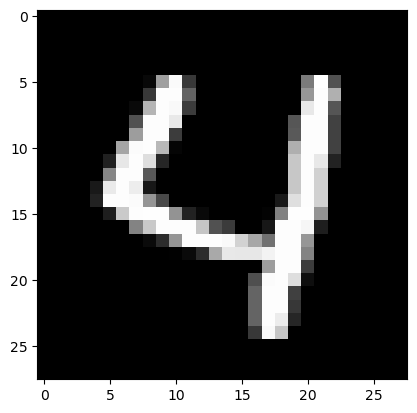

In [9]:
# 10 samples aus dem Testdatensatz vorhersagen und die Bilder mit den vorhergesagten Labels anzeigen.
with torch.no_grad():
    for image, target in test_loader:
        image, target = image.to(device), target.to(device)
        outputs = model(image)
        break

# Outputs für das erste Bild im Batch
print(outputs[0])

# Bild anzeigen
plt.imshow(image[0].cpu().squeeze(), cmap='gray')

### Softmax anwenden

In [17]:
softmax = torch.nn.Softmax(dim=0)
probabilities = softmax(outputs[0])
probabilities = probabilities.cpu().numpy().round(7)
for i in range(10):
    print(f"Klasse {i}: {probabilities[i]:.7f}")

Klasse 0: 0.0000007
Klasse 1: 0.0000000
Klasse 2: 0.0000000
Klasse 3: 0.0000000
Klasse 4: 0.9995828
Klasse 5: 0.0000004
Klasse 6: 0.0000021
Klasse 7: 0.0000008
Klasse 8: 0.0000001
Klasse 9: 0.0004131
